In [1]:
from models.ResNet import *
from utils.function import *
from utils.dataloader_custom import *
from info.OfficeHome_info import*
from tqdm import tqdm
import time
import sys
import os
import torch
import random
import numpy as np

# control random seed
random_seed = 2
random.seed(random_seed) # seed
np.random.seed(random_seed)
torch.manual_seed(random_seed)


use_domain = [0,1,2]
leave_one_domain = 3
root_path = '/home/eslab/dataset/OfficeHome/'

list_dir = os.listdir(root_path)

print(list_dir)

check_dir = []

for check_name in list_dir:
    if os.path.isdir(root_path + check_name+'/'):
        check_dir.append(root_path + check_name + '/')
        
print(check_dir)

img_list = search(root_path)

['imagelist.txt', 'Art', 'Clipart', 'Product', 'RealWorld', 'ImageInfo.csv']
['/home/eslab/dataset/OfficeHome/Art/', '/home/eslab/dataset/OfficeHome/Clipart/', '/home/eslab/dataset/OfficeHome/Product/', '/home/eslab/dataset/OfficeHome/RealWorld/']


In [2]:

# print(domain_dic)
# print(class_dic)
# print(dataset_dic)


for file_path in img_list:
    class_name = file_path.split('/')[-2]
    domain_name = file_path.split('/')[-3]
    dataset_dic[domain_name][class_name].append(file_path)
# print(domain_dic)
# print(class_dic)``

# print(dataset_dic[list(domain_dic.keys())[0]][list(class_dic.keys())[0]])

train_list,val_list, test_list, leave_list = split_officehome_dataset_leave_one_domain_out(dataset_dic,use_domain,leave_one_domain)


print(len(train_list),len(val_list),len(test_list),len(leave_list))


# train_list / val_list / test_list index = { 0: 'Art' ,  1 :'Clipart' ,  2 : 'Product', 3 : 'RealWorld'}
# if split_officehome_dataset_leave_one_domain_out second index = 3, 'RealWorld' dataset is leave one domain out test set and 0,1,2 datasets are training set(with val(early-stopping),test)




Total Domain dataset length
2427 4365 4439 4357
train_files
1991 3549 3615 3545
val_files
218 408 412 406
test_files
218 408 412 406
leave-one-domain-files length
4357
9155 1038 1038 4357


In [3]:
import torchvision.models as models
from models.ResNet import *
from torchsummary import summary

In [4]:
# model = resnet18(pretrained=True)
# summary(model.cuda(),(3,224,224))

In [5]:
# torchvision_model = models.resnet18(pretrained=True)
# summary(model.cuda(),(3,224,224))

In [6]:
#!nvidia-smi

In [7]:
import multiprocessing
epochs = 100
batch_size = 256

b1 = 0.5
b2 = 0.999

beta = 0.001
norm_square = 2

learning_rate = 0.01

image_size = 224

cpu_num = multiprocessing.cpu_count()
cuda = torch.cuda.is_available()
gpu_num = [0,1,2,3]

print(f'cpu num  = {cpu_num}')
print(f'cuda : {cuda}')
print(f'gpu num : {gpu_num}')
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
class_num = 65

cpu num  = 36
cuda : True
gpu num : [0, 1, 2, 3]


In [8]:
#train_list,val_list, test_list, leave_list
train_dataset = get_officehome_loader(data_list=train_list,image_size=image_size,training=True)
val_dataset = get_officehome_loader(data_list=val_list,image_size=image_size,training=False)
test_dataset = get_officehome_loader(data_list=test_list,image_size=image_size,training=False)
leave_one_dataset = get_officehome_loader(data_list=leave_list,image_size=image_size,training=False)

weights,count = make_weights_for_balanced_classes(train_dataset.dataset_list)

img size = 224
img size = 224
img size = 224
img size = 224


In [9]:
print(count)
weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights,len(weights))

[173, 160, 125, 147, 178, 212, 130, 130, 145, 189, 219, 106, 195, 156, 127, 119, 108, 81, 105, 125, 107, 151, 226, 169, 120, 129, 160, 194, 128, 178, 134, 117, 203, 119, 195, 116, 156, 155, 159, 104, 114, 88, 145, 135, 82, 168, 87, 112, 122, 116, 178, 117, 109, 105, 154, 116, 169, 125, 175, 126, 165, 102, 134, 135, 126]


In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset,batch_size=batch_size,sampler=sampler,num_workers=(cpu_num//4))
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=False, num_workers=(cpu_num//4))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False, num_workers=(cpu_num//4))
leave_one_dataloader = DataLoader(dataset=leave_one_dataset, batch_size=batch_size,shuffle=False, num_workers=(cpu_num//4))

In [11]:
print('='*20 + 'list length' + '='*20)
print(len(train_list),len(val_list),len(test_list),len(leave_list))
print('='*20 + 'dataloader length' + '='*20)
print(train_dataset.__len__(),val_dataset.__len__(),test_dataset.__len__(),leave_one_dataset.__len__())

====================list length====================
9155 1038 1038 4357
====================dataloader length====================
9155 1038 1038 4357


In [12]:
model = resnet18(pretrained=True)
summary(model.cuda(),(3,224,224))

https://download.pytorch.org/models/resnet18-5c106cde.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 5

/home/eslab/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
in_features = model.fc.in_features
# for key,value in model.
model.fc = nn.Linear(in_features,class_num)

In [14]:
summary(model.cuda(),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [15]:
if cuda:
        print('can use CUDA!!!')
        model = model.to(device)

can use CUDA!!!


In [16]:
if torch.cuda.device_count() > 1:
    print('Multi GPU Activation !!!', torch.cuda.device_count())
    model = nn.DataParallel(model,device_ids=gpu_num)
else:
    print('Single GPU')

Multi GPU Activation !!! 4


In [17]:

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD([{'params': model.parameters()}], lr=learning_rate, momentum=0.9)

In [18]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [19]:
total_train_loss = []
total_train_acc = []
total_val_loss = []
total_val_acc = []

for epoch in range(epochs):
    train_total_loss = 0.0
    train_total_count = 0
    train_total_data = 0
    
    val_total_loss = 0.0
    val_total_count = 0
    val_total_data = 0

    start_time = time.time()
    
    model.train()

    output_str = 'classification_lr : %f\n'%(optimizer.state_dict()['param_groups'][0]['lr'])
    sys.stdout.write(output_str)

    
    with tqdm(train_dataloader,desc='Train',unit='batch') as tepoch:
        for index,(img, label,domain) in enumerate(tepoch):
            img = img.to(device)
            label = label.long().to(device)

            optimizer.zero_grad()
            
            pred = model(img)

            loss = loss_fn(pred, label) # + beta * norm

            _, predict = torch.max(pred, 1)
            check_count = (predict == label).sum().item()

            train_total_loss += loss.item()

            train_total_count += check_count
            train_total_data += len(img)
            loss.backward()
            optimizer.step()
            accuracy = train_total_count / train_total_data
            tepoch.set_postfix(loss=train_total_loss/(index+1),accuracy=100.*accuracy)
            
    # scheduler.step(epoch)
    scheduler.step()
    
    train_total_loss /= index
    train_accuracy = train_total_count / train_total_data * 100

    output_str = 'train dataset : %d/%d epochs spend time : %.4f sec / total_loss : %.4f correct : %d/%d -> %.4f%%\n' \
                % (epoch + 1, epochs, time.time() - start_time, train_total_loss,
                    train_total_count, train_total_data, train_accuracy)
    total_train_loss.append(train_total_loss)
    total_train_acc.append(train_accuracy)
    sys.stdout.write(output_str)
    

    # check validation dataset
    start_time = time.time()
    model.eval()

    with tqdm(val_dataloader,desc='Validation',unit='batch') as tepoch:
        for index,(img, label,domain) in enumerate(tepoch):
            img = img.to(device)
            label = label.long().to(device)

            with torch.no_grad():
            
                pred = model(img)
                loss = loss_fn(pred, label) # + beta * norm


                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == label).sum().item()

                val_total_loss += loss.item()
                val_total_count += check_count
                val_total_data += len(img)
                accuracy = val_total_count / val_total_data
                tepoch.set_postfix(loss=val_total_loss/(index+1),accuracy=100.*accuracy)


    val_total_loss /= index
    val_accuracy = val_total_count / val_total_data * 100

    output_str = 'val dataset : %d/%d epochs spend time : %.4f sec  / total_loss : %.4f correct : %d/%d -> %.4f%%\n' \
                % (epoch + 1, epochs, time.time() - start_time, val_total_loss,
                    val_total_count, val_total_data, val_accuracy)
    sys.stdout.write(output_str)
    
    total_val_loss.append(val_total_loss)
    total_val_acc.append(val_accuracy)


classification_lr : 0.010000


Train: 100%|██████████| 36/36 [00:25<00:00,  1.44batch/s, accuracy=20.3, loss=3.45]
/home/eslab/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train dataset : 1/100 epochs spend time : 25.0644 sec / total_loss : 3.5483 correct : 1857/9155 -> 20.2840%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=45.7, loss=1.99]


val dataset : 1/100 epochs spend time : 3.4771 sec  / total_loss : 2.4936 correct : 474/1038 -> 45.6647%
classification_lr : 0.010000


Train: 100%|██████████| 36/36 [00:09<00:00,  3.63batch/s, accuracy=48.2, loss=2.11]


train dataset : 2/100 epochs spend time : 9.9250 sec / total_loss : 2.1739 correct : 4413/9155 -> 48.2032%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=57.4, loss=1.49]


val dataset : 2/100 epochs spend time : 3.4713 sec  / total_loss : 1.8565 correct : 596/1038 -> 57.4181%
classification_lr : 0.009998


Train: 100%|██████████| 36/36 [00:10<00:00,  3.59batch/s, accuracy=56.2, loss=1.73]


train dataset : 3/100 epochs spend time : 10.0299 sec / total_loss : 1.7798 correct : 5149/9155 -> 56.2425%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45batch/s, accuracy=60.9, loss=1.37]


val dataset : 3/100 epochs spend time : 3.4654 sec  / total_loss : 1.7174 correct : 632/1038 -> 60.8863%
classification_lr : 0.009990


Train: 100%|██████████| 36/36 [00:09<00:00,  3.63batch/s, accuracy=60.5, loss=1.53]


train dataset : 4/100 epochs spend time : 9.9345 sec / total_loss : 1.5783 correct : 5535/9155 -> 60.4588%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=62.7, loss=1.26]


val dataset : 4/100 epochs spend time : 3.5133 sec  / total_loss : 1.5765 correct : 651/1038 -> 62.7168%
classification_lr : 0.009978


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=63.5, loss=1.41]


train dataset : 5/100 epochs spend time : 9.9837 sec / total_loss : 1.4493 correct : 5812/9155 -> 63.4844%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=65.7, loss=1.22]


val dataset : 5/100 epochs spend time : 3.5136 sec  / total_loss : 1.5304 correct : 682/1038 -> 65.7033%
classification_lr : 0.009961


Train: 100%|██████████| 36/36 [00:10<00:00,  3.57batch/s, accuracy=67.2, loss=1.27]


train dataset : 6/100 epochs spend time : 10.1013 sec / total_loss : 1.3065 correct : 6155/9155 -> 67.2310%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=68.4, loss=1.08]


val dataset : 6/100 epochs spend time : 3.5083 sec  / total_loss : 1.3484 correct : 710/1038 -> 68.4008%
classification_lr : 0.009938


Train: 100%|██████████| 36/36 [00:10<00:00,  3.57batch/s, accuracy=69.2, loss=1.18]


train dataset : 7/100 epochs spend time : 10.0924 sec / total_loss : 1.2173 correct : 6331/9155 -> 69.1535%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=68.3, loss=1.18]


val dataset : 7/100 epochs spend time : 3.4966 sec  / total_loss : 1.4765 correct : 709/1038 -> 68.3044%
classification_lr : 0.009911


Train: 100%|██████████| 36/36 [00:09<00:00,  3.64batch/s, accuracy=70.7, loss=1.13]


train dataset : 8/100 epochs spend time : 9.9170 sec / total_loss : 1.1615 correct : 6472/9155 -> 70.6936%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=67.8, loss=1.06]


val dataset : 8/100 epochs spend time : 3.5294 sec  / total_loss : 1.3262 correct : 704/1038 -> 67.8227%
classification_lr : 0.009880


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=72.9, loss=1.05]


train dataset : 9/100 epochs spend time : 9.9801 sec / total_loss : 1.0771 correct : 6678/9155 -> 72.9437%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=66.6, loss=1.12]


val dataset : 9/100 epochs spend time : 3.4758 sec  / total_loss : 1.3951 correct : 691/1038 -> 66.5703%
classification_lr : 0.009843


Train: 100%|██████████| 36/36 [00:10<00:00,  3.59batch/s, accuracy=73.6, loss=1.01]


train dataset : 10/100 epochs spend time : 10.0637 sec / total_loss : 1.0434 correct : 6737/9155 -> 73.5882%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=69.2, loss=1]   


val dataset : 10/100 epochs spend time : 3.4969 sec  / total_loss : 1.2532 correct : 718/1038 -> 69.1715%
classification_lr : 0.009801


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=75.6, loss=0.933]


train dataset : 11/100 epochs spend time : 9.9592 sec / total_loss : 0.9595 correct : 6925/9155 -> 75.6417%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=68.7, loss=1.03]


val dataset : 11/100 epochs spend time : 3.4900 sec  / total_loss : 1.2902 correct : 713/1038 -> 68.6898%
classification_lr : 0.009755


Train: 100%|██████████| 36/36 [00:09<00:00,  3.60batch/s, accuracy=75.5, loss=0.92] 


train dataset : 12/100 epochs spend time : 10.0188 sec / total_loss : 0.9462 correct : 6911/9155 -> 75.4888%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=69.7, loss=1.03]


val dataset : 12/100 epochs spend time : 3.4890 sec  / total_loss : 1.2825 correct : 723/1038 -> 69.6532%
classification_lr : 0.009704


Train: 100%|██████████| 36/36 [00:10<00:00,  3.60batch/s, accuracy=76.5, loss=0.885]


train dataset : 13/100 epochs spend time : 10.0184 sec / total_loss : 0.9103 correct : 7000/9155 -> 76.4610%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=69.5, loss=1.03]


val dataset : 13/100 epochs spend time : 3.5004 sec  / total_loss : 1.2830 correct : 721/1038 -> 69.4605%
classification_lr : 0.009649


Train: 100%|██████████| 36/36 [00:10<00:00,  3.60batch/s, accuracy=77.6, loss=0.856]


train dataset : 14/100 epochs spend time : 10.0350 sec / total_loss : 0.8804 correct : 7100/9155 -> 77.5532%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=68.4, loss=1.1] 


val dataset : 14/100 epochs spend time : 3.4685 sec  / total_loss : 1.3701 correct : 710/1038 -> 68.4008%
classification_lr : 0.009589


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=78.7, loss=0.816]


train dataset : 15/100 epochs spend time : 9.9667 sec / total_loss : 0.8389 correct : 7201/9155 -> 78.6565%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=69.5, loss=1.04]


val dataset : 15/100 epochs spend time : 3.5145 sec  / total_loss : 1.3051 correct : 721/1038 -> 69.4605%
classification_lr : 0.009524


Train: 100%|██████████| 36/36 [00:10<00:00,  3.59batch/s, accuracy=78.7, loss=0.8]  


train dataset : 16/100 epochs spend time : 10.0599 sec / total_loss : 0.8233 correct : 7201/9155 -> 78.6565%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=70.1, loss=1.02]


val dataset : 16/100 epochs spend time : 3.5349 sec  / total_loss : 1.2763 correct : 728/1038 -> 70.1349%
classification_lr : 0.009455


Train: 100%|██████████| 36/36 [00:10<00:00,  3.59batch/s, accuracy=78.8, loss=0.793]


train dataset : 17/100 epochs spend time : 10.0475 sec / total_loss : 0.8153 correct : 7212/9155 -> 78.7766%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=70.1, loss=1.04]


val dataset : 17/100 epochs spend time : 3.5124 sec  / total_loss : 1.3062 correct : 728/1038 -> 70.1349%
classification_lr : 0.009382


Train: 100%|██████████| 36/36 [00:09<00:00,  3.65batch/s, accuracy=80.4, loss=0.737]


train dataset : 18/100 epochs spend time : 9.8895 sec / total_loss : 0.7584 correct : 7363/9155 -> 80.4260%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=70.9, loss=1.06]


val dataset : 18/100 epochs spend time : 3.4843 sec  / total_loss : 1.3311 correct : 736/1038 -> 70.9056%
classification_lr : 0.009304


Train: 100%|██████████| 36/36 [00:10<00:00,  3.54batch/s, accuracy=80.8, loss=0.719]


train dataset : 19/100 epochs spend time : 10.1866 sec / total_loss : 0.7395 correct : 7395/9155 -> 80.7755%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=70.1, loss=1.04]


val dataset : 19/100 epochs spend time : 3.5301 sec  / total_loss : 1.2955 correct : 728/1038 -> 70.1349%
classification_lr : 0.009222


Train: 100%|██████████| 36/36 [00:09<00:00,  3.63batch/s, accuracy=81.9, loss=0.676]


train dataset : 20/100 epochs spend time : 9.9349 sec / total_loss : 0.6952 correct : 7495/9155 -> 81.8678%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=71.4, loss=1.02]


val dataset : 20/100 epochs spend time : 3.4910 sec  / total_loss : 1.2778 correct : 741/1038 -> 71.3873%
classification_lr : 0.009135


Train: 100%|██████████| 36/36 [00:09<00:00,  3.64batch/s, accuracy=82.4, loss=0.672]


train dataset : 21/100 epochs spend time : 9.9103 sec / total_loss : 0.6911 correct : 7540/9155 -> 82.3594%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=70.2, loss=1.07]


val dataset : 21/100 epochs spend time : 3.4877 sec  / total_loss : 1.3327 correct : 729/1038 -> 70.2312%
classification_lr : 0.009045


Train: 100%|██████████| 36/36 [00:10<00:00,  3.57batch/s, accuracy=82.2, loss=0.656]


train dataset : 22/100 epochs spend time : 10.0865 sec / total_loss : 0.6745 correct : 7521/9155 -> 82.1518%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=71.4, loss=1.15]


val dataset : 22/100 epochs spend time : 3.4974 sec  / total_loss : 1.4320 correct : 741/1038 -> 71.3873%
classification_lr : 0.008951


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=83.4, loss=0.624]


train dataset : 23/100 epochs spend time : 9.9515 sec / total_loss : 0.6420 correct : 7634/9155 -> 83.3861%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=72.4, loss=0.978]


val dataset : 23/100 epochs spend time : 3.4774 sec  / total_loss : 1.2226 correct : 751/1038 -> 72.3507%
classification_lr : 0.008853


Train: 100%|██████████| 36/36 [00:09<00:00,  3.60batch/s, accuracy=83.2, loss=0.629]


train dataset : 24/100 epochs spend time : 10.0033 sec / total_loss : 0.6473 correct : 7615/9155 -> 83.1786%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=71.6, loss=1.03]


val dataset : 24/100 epochs spend time : 3.5190 sec  / total_loss : 1.2876 correct : 743/1038 -> 71.5800%
classification_lr : 0.008751


Train: 100%|██████████| 36/36 [00:10<00:00,  3.58batch/s, accuracy=84.2, loss=0.593]


train dataset : 25/100 epochs spend time : 10.0583 sec / total_loss : 0.6104 correct : 7712/9155 -> 84.2381%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=72.3, loss=1.03]


val dataset : 25/100 epochs spend time : 3.4919 sec  / total_loss : 1.2888 correct : 750/1038 -> 72.2543%
classification_lr : 0.008645


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=84.3, loss=0.584]


train dataset : 26/100 epochs spend time : 9.9833 sec / total_loss : 0.6008 correct : 7718/9155 -> 84.3037%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=71.2, loss=1.1] 


val dataset : 26/100 epochs spend time : 3.4945 sec  / total_loss : 1.3712 correct : 739/1038 -> 71.1946%
classification_lr : 0.008536


Train: 100%|██████████| 36/36 [00:10<00:00,  3.58batch/s, accuracy=84.7, loss=0.559]


train dataset : 27/100 epochs spend time : 10.0573 sec / total_loss : 0.5746 correct : 7755/9155 -> 84.7078%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=72.7, loss=1.09]


val dataset : 27/100 epochs spend time : 3.4981 sec  / total_loss : 1.3568 correct : 755/1038 -> 72.7360%
classification_lr : 0.008423


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=85.3, loss=0.547]


train dataset : 28/100 epochs spend time : 9.9977 sec / total_loss : 0.5623 correct : 7808/9155 -> 85.2867%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=72.5, loss=1.05]


val dataset : 28/100 epochs spend time : 3.4814 sec  / total_loss : 1.3121 correct : 753/1038 -> 72.5434%
classification_lr : 0.008307


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=85.1, loss=0.547]


train dataset : 29/100 epochs spend time : 9.9491 sec / total_loss : 0.5624 correct : 7790/9155 -> 85.0901%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=72.4, loss=0.994]


val dataset : 29/100 epochs spend time : 3.4775 sec  / total_loss : 1.2420 correct : 751/1038 -> 72.3507%
classification_lr : 0.008187


Train: 100%|██████████| 36/36 [00:09<00:00,  3.65batch/s, accuracy=86.1, loss=0.528]


train dataset : 30/100 epochs spend time : 9.8916 sec / total_loss : 0.5434 correct : 7884/9155 -> 86.1169%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=72.1, loss=0.975]


val dataset : 30/100 epochs spend time : 3.5286 sec  / total_loss : 1.2190 correct : 748/1038 -> 72.0617%
classification_lr : 0.008065


Train: 100%|██████████| 36/36 [00:09<00:00,  3.60batch/s, accuracy=86.3, loss=0.507]


train dataset : 31/100 epochs spend time : 10.0112 sec / total_loss : 0.5217 correct : 7900/9155 -> 86.2916%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=74.4, loss=0.991]


val dataset : 31/100 epochs spend time : 3.4776 sec  / total_loss : 1.2393 correct : 772/1038 -> 74.3738%
classification_lr : 0.007939


Train: 100%|██████████| 36/36 [00:10<00:00,  3.59batch/s, accuracy=86.7, loss=0.506]


train dataset : 32/100 epochs spend time : 10.0338 sec / total_loss : 0.5201 correct : 7939/9155 -> 86.7176%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=73.2, loss=1.03]


val dataset : 32/100 epochs spend time : 3.4707 sec  / total_loss : 1.2928 correct : 760/1038 -> 73.2177%
classification_lr : 0.007810


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=87, loss=0.49]   


train dataset : 33/100 epochs spend time : 9.9715 sec / total_loss : 0.5042 correct : 7964/9155 -> 86.9907%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=72.6, loss=1.02]


val dataset : 33/100 epochs spend time : 3.5210 sec  / total_loss : 1.2798 correct : 754/1038 -> 72.6397%
classification_lr : 0.007679


Train: 100%|██████████| 36/36 [00:10<00:00,  3.57batch/s, accuracy=86.9, loss=0.493]


train dataset : 34/100 epochs spend time : 10.1079 sec / total_loss : 0.5068 correct : 7959/9155 -> 86.9361%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=72.6, loss=1.11]


val dataset : 34/100 epochs spend time : 3.5007 sec  / total_loss : 1.3853 correct : 754/1038 -> 72.6397%
classification_lr : 0.007545


Train: 100%|██████████| 36/36 [00:10<00:00,  3.55batch/s, accuracy=86.6, loss=0.494]


train dataset : 35/100 epochs spend time : 10.1400 sec / total_loss : 0.5082 correct : 7932/9155 -> 86.6412%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=72.3, loss=0.982]


val dataset : 35/100 epochs spend time : 3.4673 sec  / total_loss : 1.2277 correct : 750/1038 -> 72.2543%
classification_lr : 0.007409


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=87.6, loss=0.461]


train dataset : 36/100 epochs spend time : 9.9953 sec / total_loss : 0.4738 correct : 8018/9155 -> 87.5806%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=72.9, loss=1.02]


val dataset : 36/100 epochs spend time : 3.4649 sec  / total_loss : 1.2771 correct : 757/1038 -> 72.9287%
classification_lr : 0.007270


Train: 100%|██████████| 36/36 [00:10<00:00,  3.59batch/s, accuracy=88.4, loss=0.445]


train dataset : 37/100 epochs spend time : 10.0437 sec / total_loss : 0.4572 correct : 8091/9155 -> 88.3779%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=74.5, loss=1.01]


val dataset : 37/100 epochs spend time : 3.4804 sec  / total_loss : 1.2586 correct : 773/1038 -> 74.4701%
classification_lr : 0.007129


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=87.6, loss=0.461]


train dataset : 38/100 epochs spend time : 9.9809 sec / total_loss : 0.4739 correct : 8016/9155 -> 87.5587%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=72.6, loss=1.08]


val dataset : 38/100 epochs spend time : 3.4820 sec  / total_loss : 1.3486 correct : 754/1038 -> 72.6397%
classification_lr : 0.006986


Train: 100%|██████████| 36/36 [00:10<00:00,  3.57batch/s, accuracy=87.8, loss=0.459]


train dataset : 39/100 epochs spend time : 10.0940 sec / total_loss : 0.4717 correct : 8041/9155 -> 87.8318%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=73.2, loss=1.03]


val dataset : 39/100 epochs spend time : 3.5155 sec  / total_loss : 1.2902 correct : 760/1038 -> 73.2177%
classification_lr : 0.006841


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=88.3, loss=0.434]


train dataset : 40/100 epochs spend time : 9.9949 sec / total_loss : 0.4461 correct : 8080/9155 -> 88.2578%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=72.8, loss=1.09]


val dataset : 40/100 epochs spend time : 3.4716 sec  / total_loss : 1.3638 correct : 756/1038 -> 72.8324%
classification_lr : 0.006694


Train: 100%|██████████| 36/36 [00:10<00:00,  3.57batch/s, accuracy=88.9, loss=0.409]


train dataset : 41/100 epochs spend time : 10.1018 sec / total_loss : 0.4207 correct : 8137/9155 -> 88.8804%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41batch/s, accuracy=73.3, loss=1.08]


val dataset : 41/100 epochs spend time : 3.5454 sec  / total_loss : 1.3492 correct : 761/1038 -> 73.3141%
classification_lr : 0.006545


Train: 100%|██████████| 36/36 [00:09<00:00,  3.60batch/s, accuracy=88.7, loss=0.424]


train dataset : 42/100 epochs spend time : 10.0060 sec / total_loss : 0.4363 correct : 8123/9155 -> 88.7275%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=73.7, loss=1.07]


val dataset : 42/100 epochs spend time : 3.4747 sec  / total_loss : 1.3391 correct : 765/1038 -> 73.6994%
classification_lr : 0.006395


Train: 100%|██████████| 36/36 [00:10<00:00,  3.59batch/s, accuracy=89.2, loss=0.413]


train dataset : 43/100 epochs spend time : 10.0444 sec / total_loss : 0.4253 correct : 8169/9155 -> 89.2299%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=72.9, loss=1.08]


val dataset : 43/100 epochs spend time : 3.4825 sec  / total_loss : 1.3535 correct : 757/1038 -> 72.9287%
classification_lr : 0.006243


Train: 100%|██████████| 36/36 [00:10<00:00,  3.59batch/s, accuracy=88.9, loss=0.412]


train dataset : 44/100 epochs spend time : 10.0499 sec / total_loss : 0.4238 correct : 8139/9155 -> 88.9022%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=74.6, loss=1.09]


val dataset : 44/100 epochs spend time : 3.5184 sec  / total_loss : 1.3578 correct : 774/1038 -> 74.5665%
classification_lr : 0.006091


Train: 100%|██████████| 36/36 [00:09<00:00,  3.63batch/s, accuracy=90, loss=0.383]  


train dataset : 45/100 epochs spend time : 9.9206 sec / total_loss : 0.3943 correct : 8238/9155 -> 89.9836%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45batch/s, accuracy=73.9, loss=1.05]


val dataset : 45/100 epochs spend time : 3.4486 sec  / total_loss : 1.3135 correct : 767/1038 -> 73.8921%
classification_lr : 0.005937


Train: 100%|██████████| 36/36 [00:10<00:00,  3.56batch/s, accuracy=90.2, loss=0.373]


train dataset : 46/100 epochs spend time : 10.1287 sec / total_loss : 0.3841 correct : 8255/9155 -> 90.1693%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=74, loss=1.04]  


val dataset : 46/100 epochs spend time : 3.5090 sec  / total_loss : 1.3013 correct : 768/1038 -> 73.9884%
classification_lr : 0.005782


Train: 100%|██████████| 36/36 [00:09<00:00,  3.66batch/s, accuracy=90.5, loss=0.369]


train dataset : 47/100 epochs spend time : 9.8568 sec / total_loss : 0.3794 correct : 8281/9155 -> 90.4533%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=74.7, loss=0.977]


val dataset : 47/100 epochs spend time : 3.5297 sec  / total_loss : 1.2212 correct : 775/1038 -> 74.6628%
classification_lr : 0.005627


Train: 100%|██████████| 36/36 [00:10<00:00,  3.56batch/s, accuracy=90.1, loss=0.383]


train dataset : 48/100 epochs spend time : 10.1159 sec / total_loss : 0.3940 correct : 8248/9155 -> 90.0928%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=73.7, loss=1.01]


val dataset : 48/100 epochs spend time : 3.5145 sec  / total_loss : 1.2620 correct : 765/1038 -> 73.6994%
classification_lr : 0.005471


Train: 100%|██████████| 36/36 [00:09<00:00,  3.64batch/s, accuracy=90.1, loss=0.372]


train dataset : 49/100 epochs spend time : 9.8989 sec / total_loss : 0.3826 correct : 8246/9155 -> 90.0710%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37batch/s, accuracy=73.8, loss=0.985]


val dataset : 49/100 epochs spend time : 3.6590 sec  / total_loss : 1.2313 correct : 766/1038 -> 73.7958%
classification_lr : 0.005314


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=90, loss=0.366]  


train dataset : 50/100 epochs spend time : 9.9760 sec / total_loss : 0.3768 correct : 8237/9155 -> 89.9727%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45batch/s, accuracy=73.7, loss=1.02]


val dataset : 50/100 epochs spend time : 3.4619 sec  / total_loss : 1.2708 correct : 765/1038 -> 73.6994%
classification_lr : 0.005157


Train: 100%|██████████| 36/36 [00:09<00:00,  3.60batch/s, accuracy=90.6, loss=0.358]


train dataset : 51/100 epochs spend time : 10.0265 sec / total_loss : 0.3684 correct : 8291/9155 -> 90.5625%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41batch/s, accuracy=74.3, loss=1.01]


val dataset : 51/100 epochs spend time : 3.5515 sec  / total_loss : 1.2619 correct : 771/1038 -> 74.2775%
classification_lr : 0.005000


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=90.9, loss=0.349]


train dataset : 52/100 epochs spend time : 9.9495 sec / total_loss : 0.3587 correct : 8318/9155 -> 90.8575%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=73.8, loss=1.03]


val dataset : 52/100 epochs spend time : 3.4842 sec  / total_loss : 1.2907 correct : 766/1038 -> 73.7958%
classification_lr : 0.004843


Train: 100%|██████████| 36/36 [00:10<00:00,  3.55batch/s, accuracy=90.9, loss=0.35] 


train dataset : 53/100 epochs spend time : 10.1567 sec / total_loss : 0.3598 correct : 8321/9155 -> 90.8902%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=73.4, loss=0.96]


val dataset : 53/100 epochs spend time : 3.5091 sec  / total_loss : 1.2003 correct : 762/1038 -> 73.4104%
classification_lr : 0.004686


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=91, loss=0.333]  


train dataset : 54/100 epochs spend time : 9.9517 sec / total_loss : 0.3429 correct : 8328/9155 -> 90.9667%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=74.6, loss=1.01]


val dataset : 54/100 epochs spend time : 3.5232 sec  / total_loss : 1.2563 correct : 774/1038 -> 74.5665%
classification_lr : 0.004529


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=91.2, loss=0.333]


train dataset : 55/100 epochs spend time : 9.9788 sec / total_loss : 0.3427 correct : 8351/9155 -> 91.2179%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41batch/s, accuracy=74.2, loss=0.985]


val dataset : 55/100 epochs spend time : 3.5463 sec  / total_loss : 1.2309 correct : 770/1038 -> 74.1811%
classification_lr : 0.004373


Train: 100%|██████████| 36/36 [00:10<00:00,  3.57batch/s, accuracy=91.1, loss=0.34] 


train dataset : 56/100 epochs spend time : 10.1079 sec / total_loss : 0.3495 correct : 8336/9155 -> 91.0541%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=72.9, loss=1.06]


val dataset : 56/100 epochs spend time : 3.5073 sec  / total_loss : 1.3222 correct : 757/1038 -> 72.9287%
classification_lr : 0.004218


Train: 100%|██████████| 36/36 [00:09<00:00,  3.64batch/s, accuracy=91.1, loss=0.333]


train dataset : 57/100 epochs spend time : 9.9078 sec / total_loss : 0.3429 correct : 8344/9155 -> 91.1415%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=73.9, loss=1.05]


val dataset : 57/100 epochs spend time : 3.4844 sec  / total_loss : 1.3153 correct : 767/1038 -> 73.8921%
classification_lr : 0.004063


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=91.5, loss=0.318]


train dataset : 58/100 epochs spend time : 9.9973 sec / total_loss : 0.3267 correct : 8376/9155 -> 91.4910%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=75, loss=1.05]  


val dataset : 58/100 epochs spend time : 3.5318 sec  / total_loss : 1.3162 correct : 779/1038 -> 75.0482%
classification_lr : 0.003909


Train: 100%|██████████| 36/36 [00:10<00:00,  3.56batch/s, accuracy=91.5, loss=0.321]


train dataset : 59/100 epochs spend time : 10.1331 sec / total_loss : 0.3298 correct : 8381/9155 -> 91.5456%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=73.2, loss=1.09]


val dataset : 59/100 epochs spend time : 3.5082 sec  / total_loss : 1.3566 correct : 760/1038 -> 73.2177%
classification_lr : 0.003757


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=91.5, loss=0.324]


train dataset : 60/100 epochs spend time : 9.9675 sec / total_loss : 0.3332 correct : 8378/9155 -> 91.5128%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=73.5, loss=1.04]


val dataset : 60/100 epochs spend time : 3.5168 sec  / total_loss : 1.3020 correct : 763/1038 -> 73.5067%
classification_lr : 0.003605


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=91.7, loss=0.315]


train dataset : 61/100 epochs spend time : 9.9880 sec / total_loss : 0.3242 correct : 8391/9155 -> 91.6548%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=74.3, loss=1.01]


val dataset : 61/100 epochs spend time : 3.5130 sec  / total_loss : 1.2593 correct : 771/1038 -> 74.2775%
classification_lr : 0.003455


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=91.9, loss=0.309]


train dataset : 62/100 epochs spend time : 9.9966 sec / total_loss : 0.3174 correct : 8413/9155 -> 91.8951%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=73.7, loss=1.04]


val dataset : 62/100 epochs spend time : 3.4952 sec  / total_loss : 1.3046 correct : 765/1038 -> 73.6994%
classification_lr : 0.003306


Train: 100%|██████████| 36/36 [00:10<00:00,  3.60batch/s, accuracy=91.7, loss=0.316]


train dataset : 63/100 epochs spend time : 10.0183 sec / total_loss : 0.3248 correct : 8395/9155 -> 91.6985%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=73.8, loss=1]   


val dataset : 63/100 epochs spend time : 3.4833 sec  / total_loss : 1.2560 correct : 766/1038 -> 73.7958%
classification_lr : 0.003159


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=92, loss=0.301]  


train dataset : 64/100 epochs spend time : 9.9472 sec / total_loss : 0.3098 correct : 8425/9155 -> 92.0262%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=74.9, loss=1.01]


val dataset : 64/100 epochs spend time : 3.5292 sec  / total_loss : 1.2680 correct : 777/1038 -> 74.8555%
classification_lr : 0.003014


Train: 100%|██████████| 36/36 [00:10<00:00,  3.58batch/s, accuracy=92, loss=0.304]  


train dataset : 65/100 epochs spend time : 10.0795 sec / total_loss : 0.3126 correct : 8422/9155 -> 91.9934%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=74, loss=1]     


val dataset : 65/100 epochs spend time : 3.4890 sec  / total_loss : 1.2525 correct : 768/1038 -> 73.9884%
classification_lr : 0.002871


Train: 100%|██████████| 36/36 [00:09<00:00,  3.64batch/s, accuracy=91.9, loss=0.306]


train dataset : 66/100 epochs spend time : 9.9170 sec / total_loss : 0.3149 correct : 8414/9155 -> 91.9061%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=74.5, loss=1.04]


val dataset : 66/100 epochs spend time : 3.5207 sec  / total_loss : 1.2953 correct : 773/1038 -> 74.4701%
classification_lr : 0.002730


Train: 100%|██████████| 36/36 [00:09<00:00,  3.64batch/s, accuracy=92.1, loss=0.302]


train dataset : 67/100 epochs spend time : 9.9065 sec / total_loss : 0.3103 correct : 8428/9155 -> 92.0590%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45batch/s, accuracy=74.2, loss=1.03]


val dataset : 67/100 epochs spend time : 3.4581 sec  / total_loss : 1.2911 correct : 770/1038 -> 74.1811%
classification_lr : 0.002591


Train: 100%|██████████| 36/36 [00:10<00:00,  3.56batch/s, accuracy=92.1, loss=0.295]


train dataset : 68/100 epochs spend time : 10.1118 sec / total_loss : 0.3031 correct : 8431/9155 -> 92.0918%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=74.6, loss=1.04]


val dataset : 68/100 epochs spend time : 3.4923 sec  / total_loss : 1.2996 correct : 774/1038 -> 74.5665%
classification_lr : 0.002455


Train: 100%|██████████| 36/36 [00:09<00:00,  3.63batch/s, accuracy=92.1, loss=0.291]


train dataset : 69/100 epochs spend time : 9.9288 sec / total_loss : 0.2990 correct : 8430/9155 -> 92.0808%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=73.2, loss=1.03]


val dataset : 69/100 epochs spend time : 3.4819 sec  / total_loss : 1.2918 correct : 760/1038 -> 73.2177%
classification_lr : 0.002321


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=92.4, loss=0.292]


train dataset : 70/100 epochs spend time : 9.9927 sec / total_loss : 0.3004 correct : 8458/9155 -> 92.3867%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=75, loss=1.03]  


val dataset : 70/100 epochs spend time : 3.5044 sec  / total_loss : 1.2920 correct : 778/1038 -> 74.9518%
classification_lr : 0.002190


Train: 100%|██████████| 36/36 [00:10<00:00,  3.53batch/s, accuracy=92.5, loss=0.283]


train dataset : 71/100 epochs spend time : 10.2320 sec / total_loss : 0.2911 correct : 8471/9155 -> 92.5287%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=74.3, loss=1.02]


val dataset : 71/100 epochs spend time : 3.4670 sec  / total_loss : 1.2692 correct : 771/1038 -> 74.2775%
classification_lr : 0.002061


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=92.8, loss=0.277]


train dataset : 72/100 epochs spend time : 9.9706 sec / total_loss : 0.2853 correct : 8497/9155 -> 92.8127%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=74.6, loss=1.08]


val dataset : 72/100 epochs spend time : 3.4782 sec  / total_loss : 1.3452 correct : 774/1038 -> 74.5665%
classification_lr : 0.001935


Train: 100%|██████████| 36/36 [00:09<00:00,  3.60batch/s, accuracy=92.6, loss=0.277]


train dataset : 73/100 epochs spend time : 10.0187 sec / total_loss : 0.2844 correct : 8478/9155 -> 92.6051%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41batch/s, accuracy=75.1, loss=1.03]


val dataset : 73/100 epochs spend time : 3.5435 sec  / total_loss : 1.2921 correct : 780/1038 -> 75.1445%
classification_lr : 0.001813


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=92.4, loss=0.28] 


train dataset : 74/100 epochs spend time : 9.9942 sec / total_loss : 0.2882 correct : 8460/9155 -> 92.4085%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=75, loss=1.03]  


val dataset : 74/100 epochs spend time : 3.4719 sec  / total_loss : 1.2874 correct : 779/1038 -> 75.0482%
classification_lr : 0.001693


Train: 100%|██████████| 36/36 [00:09<00:00,  3.63batch/s, accuracy=92.9, loss=0.276]


train dataset : 75/100 epochs spend time : 9.9333 sec / total_loss : 0.2836 correct : 8503/9155 -> 92.8782%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=75.4, loss=1.01]


val dataset : 75/100 epochs spend time : 3.4935 sec  / total_loss : 1.2585 correct : 783/1038 -> 75.4335%
classification_lr : 0.001577


Train: 100%|██████████| 36/36 [00:09<00:00,  3.64batch/s, accuracy=92.6, loss=0.278]


train dataset : 76/100 epochs spend time : 9.8897 sec / total_loss : 0.2862 correct : 8474/9155 -> 92.5614%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=74.8, loss=1.04]


val dataset : 76/100 epochs spend time : 3.5119 sec  / total_loss : 1.3019 correct : 776/1038 -> 74.7592%
classification_lr : 0.001464


Train: 100%|██████████| 36/36 [00:10<00:00,  3.56batch/s, accuracy=92.4, loss=0.285]


train dataset : 77/100 epochs spend time : 10.1416 sec / total_loss : 0.2934 correct : 8457/9155 -> 92.3758%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=75, loss=1.04]  


val dataset : 77/100 epochs spend time : 3.4835 sec  / total_loss : 1.3009 correct : 779/1038 -> 75.0482%
classification_lr : 0.001355


Train: 100%|██████████| 36/36 [00:09<00:00,  3.68batch/s, accuracy=92.5, loss=0.287]


train dataset : 78/100 epochs spend time : 9.8082 sec / total_loss : 0.2952 correct : 8466/9155 -> 92.4741%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=75.5, loss=1.01]


val dataset : 78/100 epochs spend time : 3.4766 sec  / total_loss : 1.2583 correct : 784/1038 -> 75.5299%
classification_lr : 0.001249


Train: 100%|██████████| 36/36 [00:10<00:00,  3.58batch/s, accuracy=92.6, loss=0.278]


train dataset : 79/100 epochs spend time : 10.0866 sec / total_loss : 0.2858 correct : 8475/9155 -> 92.5724%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=74.6, loss=1.04]


val dataset : 79/100 epochs spend time : 3.5125 sec  / total_loss : 1.2978 correct : 774/1038 -> 74.5665%
classification_lr : 0.001147


Train: 100%|██████████| 36/36 [00:09<00:00,  3.60batch/s, accuracy=93.2, loss=0.258]


train dataset : 80/100 epochs spend time : 9.9994 sec / total_loss : 0.2654 correct : 8533/9155 -> 93.2059%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=74.9, loss=1.06]


val dataset : 80/100 epochs spend time : 3.4927 sec  / total_loss : 1.3255 correct : 777/1038 -> 74.8555%
classification_lr : 0.001049


Train: 100%|██████████| 36/36 [00:10<00:00,  3.57batch/s, accuracy=92.8, loss=0.274]


train dataset : 81/100 epochs spend time : 10.0932 sec / total_loss : 0.2817 correct : 8495/9155 -> 92.7908%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=75, loss=1.02]  


val dataset : 81/100 epochs spend time : 3.4906 sec  / total_loss : 1.2780 correct : 778/1038 -> 74.9518%
classification_lr : 0.000955


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=93, loss=0.267]  


train dataset : 82/100 epochs spend time : 9.9602 sec / total_loss : 0.2748 correct : 8518/9155 -> 93.0421%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=75.1, loss=1.01]


val dataset : 82/100 epochs spend time : 3.5342 sec  / total_loss : 1.2638 correct : 780/1038 -> 75.1445%
classification_lr : 0.000865


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=93.3, loss=0.254]


train dataset : 83/100 epochs spend time : 9.9780 sec / total_loss : 0.2616 correct : 8540/9155 -> 93.2824%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=75.2, loss=1.05]


val dataset : 83/100 epochs spend time : 3.4979 sec  / total_loss : 1.3071 correct : 781/1038 -> 75.2408%
classification_lr : 0.000778


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=93, loss=0.263]  


train dataset : 84/100 epochs spend time : 9.9469 sec / total_loss : 0.2707 correct : 8515/9155 -> 93.0093%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45batch/s, accuracy=75.4, loss=1.04]


val dataset : 84/100 epochs spend time : 3.4588 sec  / total_loss : 1.2960 correct : 783/1038 -> 75.4335%
classification_lr : 0.000696


Train: 100%|██████████| 36/36 [00:09<00:00,  3.60batch/s, accuracy=93.2, loss=0.256]


train dataset : 85/100 epochs spend time : 10.0005 sec / total_loss : 0.2629 correct : 8534/9155 -> 93.2168%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=75, loss=1.05]  


val dataset : 85/100 epochs spend time : 3.4912 sec  / total_loss : 1.3095 correct : 778/1038 -> 74.9518%
classification_lr : 0.000618


Train: 100%|██████████| 36/36 [00:10<00:00,  3.58batch/s, accuracy=93.7, loss=0.247]


train dataset : 86/100 epochs spend time : 10.0709 sec / total_loss : 0.2536 correct : 8578/9155 -> 93.6974%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=75.5, loss=1.02]


val dataset : 86/100 epochs spend time : 3.5200 sec  / total_loss : 1.2741 correct : 784/1038 -> 75.5299%
classification_lr : 0.000545


Train: 100%|██████████| 36/36 [00:10<00:00,  3.59batch/s, accuracy=93.2, loss=0.26] 


train dataset : 87/100 epochs spend time : 10.0355 sec / total_loss : 0.2679 correct : 8530/9155 -> 93.1731%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=75.4, loss=1.03]


val dataset : 87/100 epochs spend time : 3.5039 sec  / total_loss : 1.2865 correct : 783/1038 -> 75.4335%
classification_lr : 0.000476


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=93.4, loss=0.257]


train dataset : 88/100 epochs spend time : 9.9680 sec / total_loss : 0.2648 correct : 8547/9155 -> 93.3588%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=74.8, loss=1.02]


val dataset : 88/100 epochs spend time : 3.4768 sec  / total_loss : 1.2756 correct : 776/1038 -> 74.7592%
classification_lr : 0.000411


Train: 100%|██████████| 36/36 [00:10<00:00,  3.54batch/s, accuracy=94.1, loss=0.235]


train dataset : 89/100 epochs spend time : 10.1939 sec / total_loss : 0.2413 correct : 8616/9155 -> 94.1125%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=74.8, loss=1.02]


val dataset : 89/100 epochs spend time : 3.4907 sec  / total_loss : 1.2735 correct : 776/1038 -> 74.7592%
classification_lr : 0.000351


Train: 100%|██████████| 36/36 [00:09<00:00,  3.64batch/s, accuracy=93.4, loss=0.251]


train dataset : 90/100 epochs spend time : 9.8954 sec / total_loss : 0.2579 correct : 8549/9155 -> 93.3807%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=74.9, loss=1.02]


val dataset : 90/100 epochs spend time : 3.4876 sec  / total_loss : 1.2759 correct : 777/1038 -> 74.8555%
classification_lr : 0.000296


Train: 100%|██████████| 36/36 [00:10<00:00,  3.58batch/s, accuracy=93.2, loss=0.248]


train dataset : 91/100 epochs spend time : 10.0801 sec / total_loss : 0.2555 correct : 8536/9155 -> 93.2387%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=75, loss=1.04]  


val dataset : 91/100 epochs spend time : 3.4973 sec  / total_loss : 1.2950 correct : 779/1038 -> 75.0482%
classification_lr : 0.000245


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=93.4, loss=0.25] 


train dataset : 92/100 epochs spend time : 9.9765 sec / total_loss : 0.2573 correct : 8551/9155 -> 93.4025%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=74.8, loss=1.03]


val dataset : 92/100 epochs spend time : 3.4771 sec  / total_loss : 1.2893 correct : 776/1038 -> 74.7592%
classification_lr : 0.000199


Train: 100%|██████████| 36/36 [00:09<00:00,  3.61batch/s, accuracy=93.2, loss=0.253]


train dataset : 93/100 epochs spend time : 9.9861 sec / total_loss : 0.2597 correct : 8533/9155 -> 93.2059%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=75.1, loss=1.03]


val dataset : 93/100 epochs spend time : 3.5180 sec  / total_loss : 1.2813 correct : 780/1038 -> 75.1445%
classification_lr : 0.000157


Train: 100%|██████████| 36/36 [00:10<00:00,  3.56batch/s, accuracy=93.4, loss=0.255]


train dataset : 94/100 epochs spend time : 10.1259 sec / total_loss : 0.2627 correct : 8549/9155 -> 93.3807%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s, accuracy=74.9, loss=1.04]


val dataset : 94/100 epochs spend time : 3.5044 sec  / total_loss : 1.2941 correct : 777/1038 -> 74.8555%
classification_lr : 0.000120


Train: 100%|██████████| 36/36 [00:10<00:00,  3.56batch/s, accuracy=93.4, loss=0.249]


train dataset : 95/100 epochs spend time : 10.1126 sec / total_loss : 0.2565 correct : 8550/9155 -> 93.3916%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37batch/s, accuracy=74.8, loss=1.02]


val dataset : 95/100 epochs spend time : 3.6451 sec  / total_loss : 1.2710 correct : 776/1038 -> 74.7592%
classification_lr : 0.000089


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=93.9, loss=0.232]


train dataset : 96/100 epochs spend time : 9.9704 sec / total_loss : 0.2386 correct : 8592/9155 -> 93.8504%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s, accuracy=75, loss=1.04]  


val dataset : 96/100 epochs spend time : 3.4742 sec  / total_loss : 1.3026 correct : 779/1038 -> 75.0482%
classification_lr : 0.000062


Train: 100%|██████████| 36/36 [00:09<00:00,  3.62batch/s, accuracy=93.4, loss=0.249]


train dataset : 97/100 epochs spend time : 9.9529 sec / total_loss : 0.2565 correct : 8547/9155 -> 93.3588%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40batch/s, accuracy=74.3, loss=1.03]


val dataset : 97/100 epochs spend time : 3.5664 sec  / total_loss : 1.2857 correct : 771/1038 -> 74.2775%
classification_lr : 0.000039


Train: 100%|██████████| 36/36 [00:10<00:00,  3.58batch/s, accuracy=93.6, loss=0.248]


train dataset : 98/100 epochs spend time : 10.0751 sec / total_loss : 0.2556 correct : 8572/9155 -> 93.6319%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39batch/s, accuracy=74.2, loss=1.03]


val dataset : 98/100 epochs spend time : 3.6152 sec  / total_loss : 1.2870 correct : 770/1038 -> 74.1811%
classification_lr : 0.000022


Train: 100%|██████████| 36/36 [00:09<00:00,  3.64batch/s, accuracy=93.2, loss=0.258]


train dataset : 99/100 epochs spend time : 9.9154 sec / total_loss : 0.2656 correct : 8533/9155 -> 93.2059%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s, accuracy=75, loss=1.03]  


val dataset : 99/100 epochs spend time : 3.5179 sec  / total_loss : 1.2855 correct : 778/1038 -> 74.9518%
classification_lr : 0.000010


Train: 100%|██████████| 36/36 [00:10<00:00,  3.59batch/s, accuracy=93.2, loss=0.266]


train dataset : 100/100 epochs spend time : 10.0506 sec / total_loss : 0.2733 correct : 8532/9155 -> 93.1950%


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45batch/s, accuracy=75, loss=1.02]  

val dataset : 100/100 epochs spend time : 3.4578 sec  / total_loss : 1.2758 correct : 779/1038 -> 75.0482%


In [20]:
!nvidia-smi

Tue Aug  2 23:01:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
|  0%   46C    P2   336W / 350W |  10341MiB / 24268MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:1A:00.0 Off |                  N/A |
|  0%   

In [21]:
import matplotlib.pyplot as plt

<class 'float'>


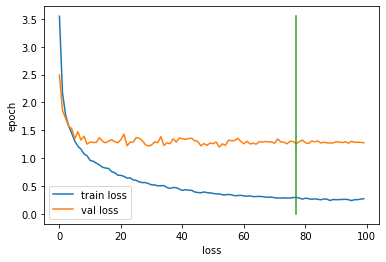

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(np.array(total_train_loss),label='train loss')
plt.plot(np.array(total_val_loss),label='val loss')
plt.plot([np.array(total_val_acc).argmax(),np.array(total_val_acc).argmax()],[0,np.array(total_train_loss).max()])
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend()
plt.show()
plt.cla()
plt.clf()

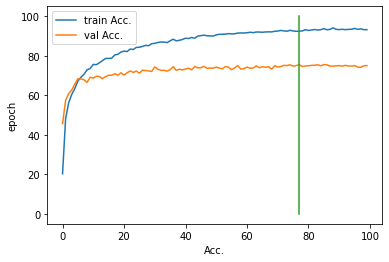

<Figure size 432x288 with 0 Axes>

In [41]:
plt.plot(np.array(total_train_acc),label='train Acc.')
plt.plot(np.array(total_val_acc),label='val Acc.')
plt.plot([np.array(total_val_acc).argmax(),np.array(total_val_acc).argmax()],[0,100])
plt.xlabel('Acc.')
plt.ylabel('epoch')
plt.legend()
plt.show()
plt.cla()
plt.clf()

In [42]:
!nvidia-smi

Tue Aug  2 23:12:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
|  0%   46C    P2   335W / 350W |  10341MiB / 24268MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:1A:00.0 Off |                  N/A |
|  0%   